In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pmdarima.arima import auto_arima
import yfinance 
import warnings
warnings.filterwarnings('ignore')

In [6]:
raw_data = yfinance.download(tickers=["ICICIBANK.NS", "^NSEBANK"], start="2014-12-31", end="2021-01-01", group_by="ticker", auto_adjust=True, interval="1d", treads=True)

[*********************100%***********************]  2 of 2 completed


In [8]:
df = raw_data.copy()

In [9]:
df["nsebank"] = df["^NSEBANK"].Close
df["icici"] = df["ICICIBANK.NS"].Close

del  df["^NSEBANK"], df["ICICIBANK.NS"]
df.head()

,nsebank,icici
,,
Date,,
2014-12-31,18736.650391,300.588135
2015-01-01,NaN,299.907104
2015-01-02,19057.800781,308.419952
2015-01-05,19017.400391,309.058350
2015-01-06,18430.750000,295.948639


In [10]:
df = df.asfreq("b")
df = df.fillna(method="ffill")

In [12]:
returns =["icici_ret", "nsebank_ret"]
df["nsebank_ret"] = df.nsebank.pct_change(1)*100
df["icici_ret"] = df.icici.pct_change(1)*100

In [17]:
df.head()

,nsebank,icici,nsebank_ret,icici_ret
,,,,
Date,,,,
2014-12-31,18736.650391,300.588135,NaN,NaN
2015-01-01,18736.650391,299.907104,0.000000,-0.226566
2015-01-02,19057.800781,308.419952,1.714022,2.838495
2015-01-05,19017.400391,309.058350,-0.211989,0.206990
2015-01-06,18430.750000,295.948639,-3.084809,-4.241824


In [18]:
df_ret = df[returns][1:]
df_ret = df_ret.rename(columns={"nsebank_ret": "nsebank", "icici_ret": "icici"})
df_ret.head()

,icici,nsebank
,,
Date,,
2015-01-01,-0.226566,0.000000
2015-01-02,2.838495,1.714022
2015-01-05,0.206990,-0.211989
2015-01-06,-4.241824,-3.084809
2015-01-07,-2.703873,-0.686353


In [35]:
start_date= "2019-12-31"
end_date="2021-01-01"
X_train = df_ret[ :start_date]
X_test = df_ret[start_date:end_date][1:]

In [36]:
X_train.tail()

,icici,nsebank
,,
Date,,
2019-12-25,0.000000,0.000000
2019-12-26,-0.434296,-0.876841
2019-12-27,1.976803,1.295876
2019-12-30,-0.991993,-0.177245
2019-12-31,-0.928392,-0.597282


In [37]:
X_test.head()

,icici,nsebank
,,
Date,,
2020-01-01,-0.398965,0.000000
2020-01-02,0.717275,0.877440
2020-01-03,-0.323714,-1.154609
2020-01-06,-2.440376,-2.594696
2020-01-07,-0.532621,0.519414


In [39]:
sts.adfuller(X_train.icici)

(-35.32291254327654,
 0.0,
 0,
 1303,
 {'1%': -3.435378572037035,
  '5%': -2.863760700696655,
  '10%': -2.56795231450063},
 5290.52840160167)

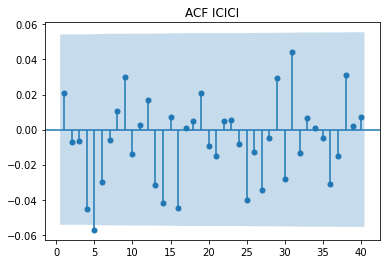

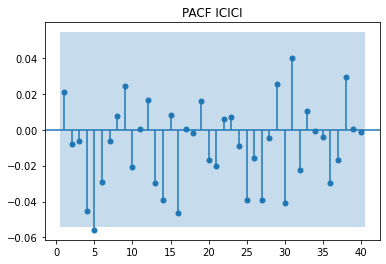

In [40]:
sgt.plot_acf(X_train.icici, lags=40, zero=False)
plt.title("ACF ICICI")
sgt.plot_pacf(X_train.icici, lags= 40, zero=False)
plt.title("PACF ICICI")
plt.show()

In [41]:
model = auto_arima(X_train.icici, exogeneous =df_ret[["nsebank"]] )
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1304
Model:                        SARIMAX   Log Likelihood               -2699.223
Date:                Mon, 22 Feb 2021   AIC                           5400.447
Time:                        09:34:02   BIC                           5405.620
Sample:                             0   HQIC                          5402.388
                               - 1304                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.6768      0.077     47.939      0.000       3.526       3.827
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              1497.59
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

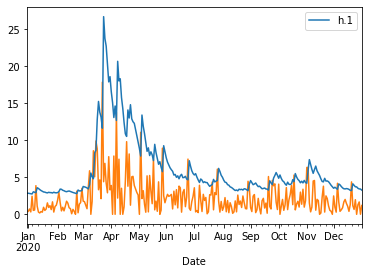

In [65]:
pred_garch = results1.forecast(horizon=1, align="target")
pred_garch.residual_variance[start_date:].plot(zorder=2)
X_test.icici.abs().plot(zorder=1)
plt.show()

In [71]:
pred_garch = results1.forecast(
                        horizon=120,
                        align="target"
)
pred_120 =pred_garch.residual_variance[-1:]

In [73]:
pred_120.T

Date,2020-12-31
h.001,3.270646
h.002,3.445693
h.003,3.487122
h.004,3.572597
h.005,3.706903
...,...
h.116,3.705843
h.117,3.705844
h.118,3.705843
h.119,3.705842


In [76]:
pred_garch = results1.forecast(
                        horizon=50,
                        align="target"
)
pred_50 =pred_garch.residual_variance[-1:]

<AxesSubplot:>

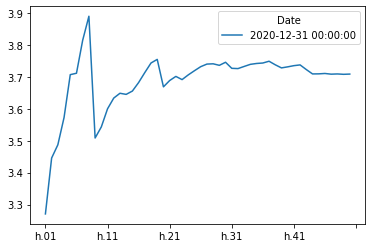

In [77]:
pred_50.T.plot()

In [86]:
pred_garch = results1.forecast(
                        horizon=50,
                        align="target"
)
pred_50 =pred_garch.residual_variance[-30:]

<AxesSubplot:>

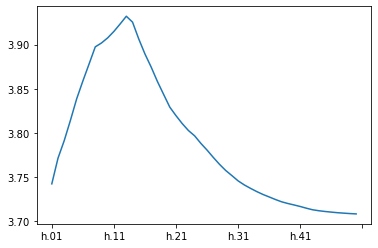

In [88]:
pred_50.mean().T.plot()


In [89]:
pred_garch = results1.forecast(
                        horizon=100,
                        align="target"
)
pred_100 =pred_garch.residual_variance[-30:]

<AxesSubplot:>

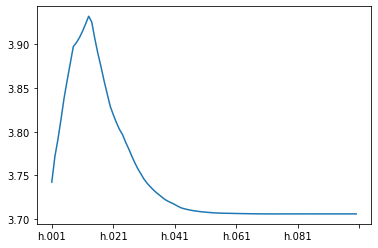

In [90]:
pred_100.mean().T.plot()
